#### Notebook for implementing and testing propagators

##### Imports and definitions

In [1]:
import numpy as np
import time as tm
import math
import scipy.constants as const
import copy
from pykern import pkcli
from pykern.pkcollections import PKDict

import srwlib
from srwlib import srwl
from srwlib import *

# from pulse import pulse
# import rslaser.pulse.pulse as pulse
# import srwl_uti_data as srwutil
# import rslaser.pulse as pulse
from rslaser.pulse import pulse as pulse
from rslaser.utils import srwl_uti_data as srwutil
from rslaser.optics import element as element
from rsmath import lct as rslct
# import sys
#     # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, '/../../rslaser/utils')


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# plt.style.use('Solarize_Light2')
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 15}

***
##### Create laser pulse and extract fields

In [2]:
phE = 0.124    # photon energy [eV]
hc_ev_um = 1.23984198   # hc [eV*um]
phLambda = hc_ev_um / phE * 1e-6 # wavelength corresponding to phE in meters
print("Wavelength corresponding to %g keV: %g microns" %(phE * 1e-3, phLambda / 1e-6))

w0 = 1.275e-3            # waist size [m] for pumped wavefront from data02.ipynb
sigx_waist = w0 / 2      # beam size at waist [m]
sigy_waist = w0 / 2      # beam size at waist [m]
print('sigx_waist: %g [mm], sigy_waist: %g [mm]' %(sigx_waist* 1e3, sigy_waist * 1e3))

z_R_x = 4 * np.pi * sigx_waist**2 / phLambda    # horizontal Rayleigh range [m]
z_R_y = 4 * np.pi * sigy_waist**2 / phLambda    # verrtical Rayleigh range [m]
print(r'z_{R_x} = %g [m], z_{R_y} = %g [m]' %(z_R_x, z_R_y))

sig_s = z_R_x
tau_fwhm = sig_s / const.c * 2.355

Wavelength corresponding to 0.000124 keV: 9.99873 microns
sigx_waist: 0.6375 [mm], sigy_waist: 0.6375 [mm]
z_{R_x} = 0.51077 [m], z_{R_y} = 0.51077 [m]


In [3]:
# specify parameters
slice_params = PKDict(
    sigx_waist = sigx_waist,
    sigy_waist = sigy_waist,
    num_sig_trans = 24,    #24
    nx_slice = 1200,
    ny_slice = 1200,
    pulseE = 0.001,
    poltype = 1,
    mx = 0,
    my = 0,
)

pulse_params = PKDict(
        nslice = 1,
        chirp = 0,
        phE = phE,
        num_sig_long = 4,
        dist_waist = 0,
        # tau_fwhm = 0.1 / const.c / math.sqrt(2.),
        tau_fwhm = tau_fwhm,
        slice_params = slice_params,
)

params = pulse_params.copy()

In [4]:
# create laser pulse and a copy for second propagation (via SRW)
pulse_init = pulse.LaserPulse(params)
# pulse_init_srw = copy.deepcopy(pulse_init)

# calculate center slice index at waist
nslice_cen = int(pulse_params['nslice'] / 2)
print(nslice_cen)

# create separate single laser slice
slice_init = pulse.LaserPulseSlice(nslice_cen, params = pulse_params)

0


In [5]:
# help(pulse_init)

In [6]:
slice_vals = np.arange(0, pulse_params['nslice'], 1)
print(np.size(slice_vals))
rmsx_vals = pulse_init.rmsvals()[0]
print(np.size(rmsx_vals))
rmsy_vals = pulse_init.rmsvals()[1]
long_int_vals = pulse_init.intensity_vals()


1
1


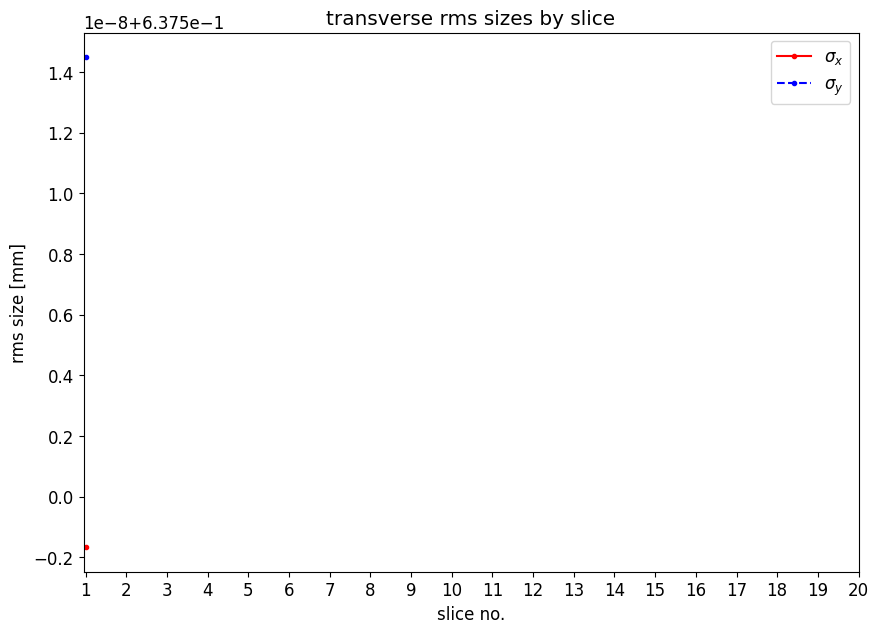

In [7]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(slice_vals + 1, np.multiply(rmsx_vals, 1e3), 'r.-', label = r'$\sigma_x$')
ax.plot(slice_vals + 1, np.multiply(rmsy_vals, 1e3), 'b.--',  label = r'$\sigma_y$')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set_xticks(range(1,21))
# plt.xlim(0,350)
# plt.ylim(0,100)
plt.title('transverse rms sizes by slice')
plt.xlabel('slice no.')
plt.ylabel('rms size [mm]')
plt.legend()

In [8]:
# slice_vals = np.arange(1, _LASER_PULSE_DEFAULTS['nslice'] + 1, 1)
# rmsx_vals = pulse_init.rmsvals()[0]
# rmsy_vals = pulse_init.rmsvals()[1]
# long_int_vals = pulse_init.intensity_vals()

In [9]:
# print('rmsx_vals: %s [mm]' %(np.multiply(rmsx_vals, 1e3)))
# print('rmsy_vals: %s [mm]' %(np.multiply(rmsy_vals, 1e3)))

In [10]:
# fig = plt.figure(figsize = (10, 7))
# ax = fig.gca()

# ax.plot(slice_vals, rmsx_vals, 'r.-', label = r'$\sigma_x$')
# ax.plot(slice_vals, rmsy_vals, 'b.--',  label = r'$\sigma_y$')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# # plt.xlim(0,350)
# # plt.ylim(0,100)
# plt.title('transverse rms sizes by slice')
# plt.xlabel('slice no.')
# plt.ylabel('rms size [m]')
# plt.legend()

In [11]:
wfr0 = slice_init.wfr

# create a deepcopy for use in SRW propagation later


In [12]:
# calculate phase, E field, and intensity from initial Gsn wavefront
int0, int0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase0, phase0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re0, re0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im0, im0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.15 s)
Extracting intensity and saving it to a file ... completed (lasted 0.18 s)
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)
Extracting intensity and saving it to a file ... completed (lasted 0.14 s)


In [13]:
# reshape into 2D Gsn phase, E field, and intensity arrays
int0_2d = np.array(int0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
phase0_2d = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
re0_2d = np.array(re0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
im0_2d = np.array(im0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
print('Size of initial mesh (coordinate):',np.shape(int0_2d))

Size of initial mesh (coordinate): (1200, 1200)


In [14]:
# create corresponding x and y arrays for 2D Gsn phase, E field, and intensity arrays
xvals_gsn_init=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvals_gsn_init=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

In [15]:
# calculate E field total from Re(E) and Im(E)
E_field_gsn_init = re0_2d + np.multiply(im0_2d, 1j)

Text(0.5, 1.0, 'Initial Wavefront Intensity')

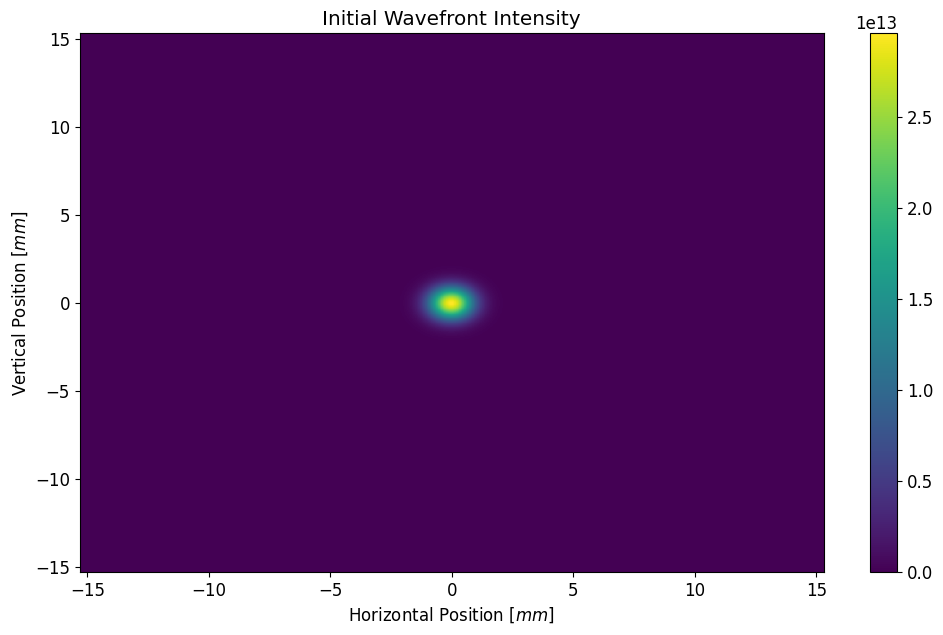

In [16]:
# plot initial intensity
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Intensity')

Text(0.5, 1.0, 'Initial Wavefront Re(E)')

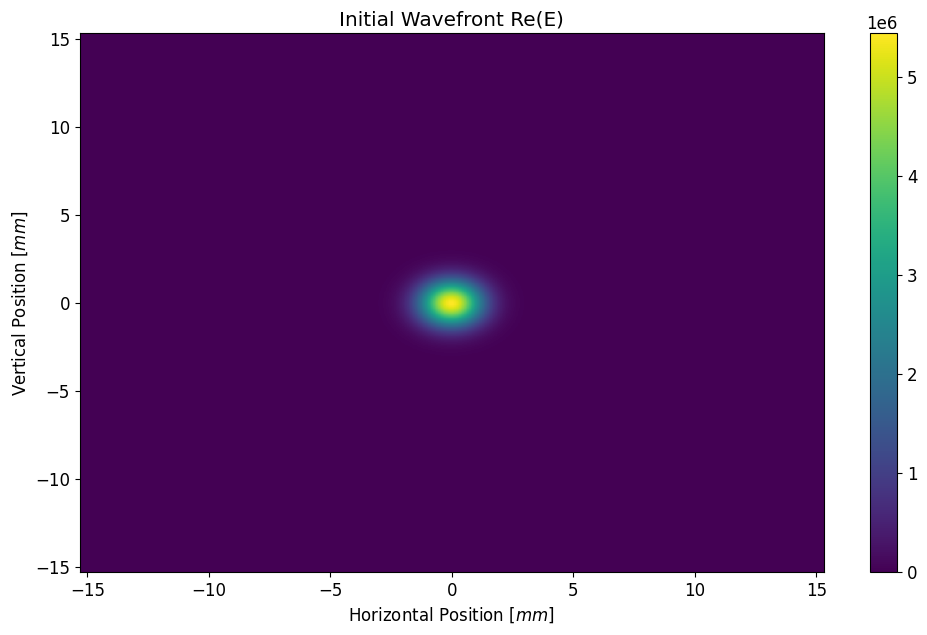

In [17]:
# plot initial Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), re0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Re(E)')

Text(0.5, 1.0, 'Initial Wavefront Im(E)')

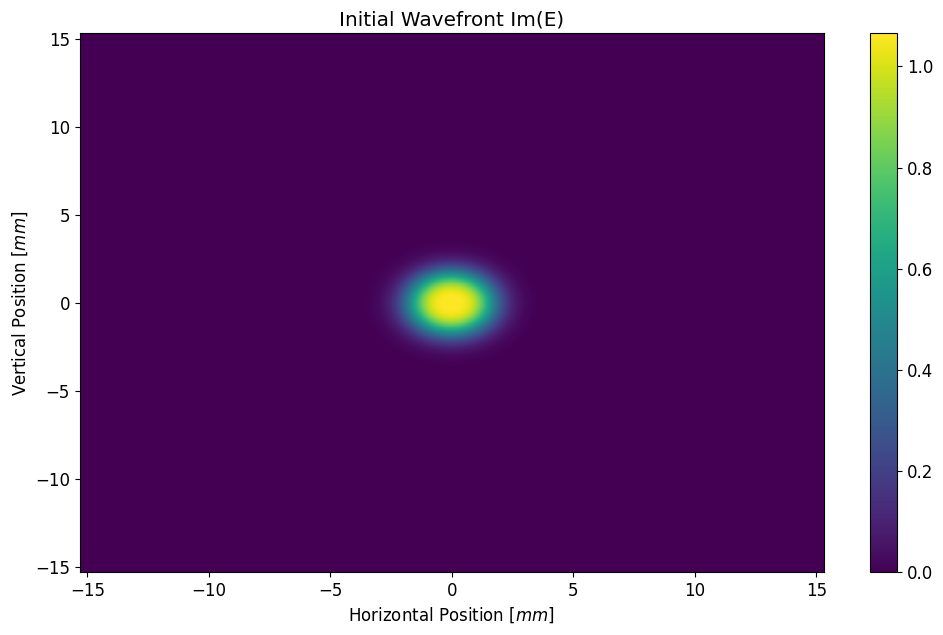

In [18]:
# plot initial Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), im0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), im0_2d, cmap = plt.cm.get_cmap('cool'), shading='auto')
plt.colorbar()

cmap = plt.cm.get_cmap('Reds')

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)

ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Im(E)')

Text(0.5, 1.0, 'Initial Wavefront Phase')

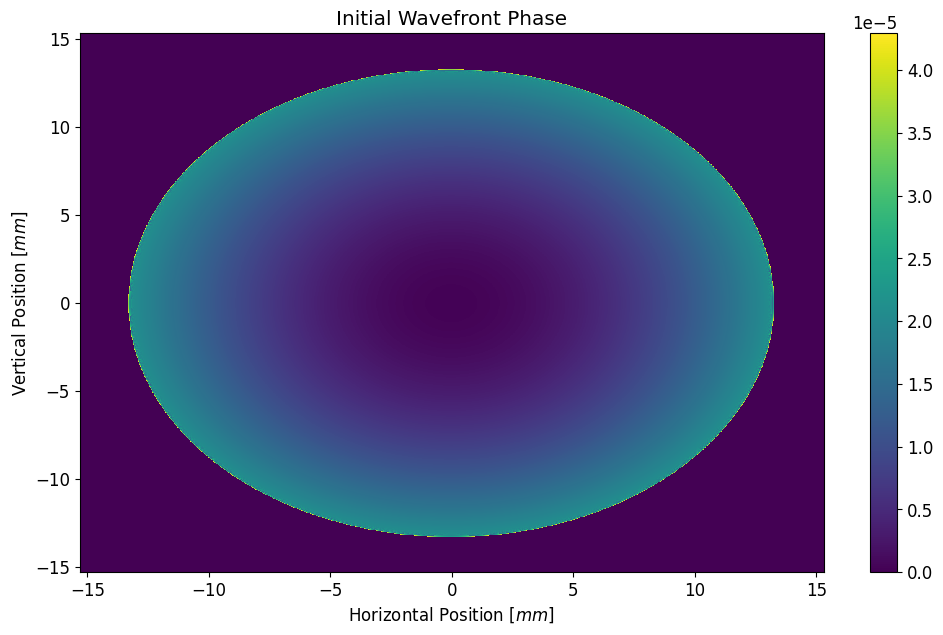

In [19]:
# plot initial phase
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), phase0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Phase')

In [20]:
# find center indeces of initial wavefront data
jx_cen_init = np.floor(len(xvals_gsn_init) / 2).astype(int)
jy_cen_init = np.floor(len(yvals_gsn_init) / 2).astype(int)
print(jx_cen_init, jy_cen_init)

600 600


In [21]:
# take horizontal slices of initial wavefront data
int_slice_hor_init = int0_2d[:, jy_cen_init]
re_slice_hor_init = np.real(E_field_gsn_init)[:, jy_cen_init]
print(np.shape(re_slice_hor_init))
im_slice_hor_init = np.imag(E_field_gsn_init)[:, jy_cen_init]
phase_slice_hor_init = phase0_2d[:, jy_cen_init]

(1200,)


***
##### Create crystal element and propagate via n0n2 LCT

In [22]:
# construct ABCD matrix and perform decomposition to estimate scale factor
A = 0.99964491
B = 0.02499704
C = -0.02840573
D = 0.99964491

n0 = 1.76            # n0
n2 = 2               # n2 [1/m^2]
len_cryst = 0.025    # crystal length [m]
nslice_cryst = 3     # no. of crystal slices
l_scale = 5e-3       # scale factor

gamma = np.sqrt(n2/n0)
A_dec = np.cos(gamma*len_cryst/nslice_cryst)
B_dec = (1/gamma)*np.sin(gamma*len_cryst/nslice_cryst) * phLambda / (l_scale**2)
C_dec = -gamma*np.sin(gamma*len_cryst/nslice_cryst) / phLambda * (l_scale**2)
D_dec = np.cos(gamma*len_cryst/nslice_cryst)

# A_dec = A
# B_dec = B * phLambda / (l_scale**2)
# C_dec = C / phLambda * (l_scale**2)
# D_dec = D
            
abcd_mat_cryst_dec = np.array([[ A_dec,  B_dec  ],
                     [ C_dec, D_dec ]])

print('A_dec: %g, B_dec: %g, C_dec: %g, D_dec: %g' %(A_dec, B_dec, C_dec, D_dec))
    
print(rslct.lct_decomposition(abcd_mat_cryst_dec))

A_dec: 0.999961, B_dec: 0.00333286, C_dec: -0.0236769, D_dec: 0.999961
[['SCL', -0.999960543188769], ['LCFT', 0], ['RSMP', 2.0], ['CM', 0.00333273320874347], ['LCFT', 0], ['RSMP', 0.5135835487435219], ['CM', 0.023677882590448007]]


In [23]:
crystal_params = PKDict(
        n0 = n0,
        n2 = n2,
        length = len_cryst,
        nslice = nslice_cryst,
        l_scale = l_scale,
        A = A,
        B = B,
        C = C,
        D = D
)

# params = pulse_params.copy()

prop_type = 'n0n2_lct'
# prop_type = 'n0n2'

crystal_obj = element.Crystal(crystal_params)

In [24]:
pulse_prop_lct = crystal_obj.propagate(pulse_init, prop_type)
wfr1_lct = pulse_prop_lct.slice[nslice_cen].wfr

prop_type = n0n2_lct
Wavelength corresponding to 0.000124 keV: 9.99873 microns
A: 0.999961
B: 0.00333286
C: -0.0236769
D: 0.999961
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
prop_type = n0n2_lct
Wavelength corresponding to 0.000124 keV: 9.99873 microns
A: 0.999961
B: 0.00333286
C: -0.0236769
D: 0.999961
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
prop_type = n0n2_lct
Wavelength corresponding to 0.000124 keV: 9.99873 microns
A: 0.999961
B: 0.00333286
C: -0.0236769
D: 0.999961
Extract

In [25]:
# calculate phase, E field, and intensity from LCT-propagated Gsn wavefront
int1_lct, int1_mesh_lct = srwutil.calc_int_from_wfr(wfr1_lct, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase1_lct, phase1_mesh_lct = srwutil.calc_int_from_wfr(wfr1_lct, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re1_lct, re1_mesh_lct = srwutil.calc_int_from_wfr(wfr1_lct, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im1_lct, im1_mesh_lct = srwutil.calc_int_from_wfr(wfr1_lct, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.13 s)
Extracting intensity and saving it to a file ... completed (lasted 0.19 s)
Extracting intensity and saving it to a file ... completed (lasted 0.13 s)
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)


In [26]:
# reshape into 2D Gsn phase, E field, and intensity arrays
int1_2d_lct = np.array(int1_lct).reshape((wfr1_lct.mesh.nx, wfr1_lct.mesh.ny), order='C')
phase1_2d_lct = np.array(phase1_lct).reshape((wfr1_lct.mesh.nx, wfr1_lct.mesh.ny), order='C')
re1_2d_lct = np.array(re1_lct).reshape((wfr1_lct.mesh.nx, wfr1_lct.mesh.ny), order='C')
im1_2d_lct = np.array(im1_lct).reshape((wfr1_lct.mesh.nx, wfr1_lct.mesh.ny), order='C')
print('Size of propagated mesh (coordinate):',np.shape(int1_2d_lct))

Size of propagated mesh (coordinate): (1302, 1302)


In [27]:
# create corresponding x and y arrays for 2D Gsn phase, E field, and intensity arrays
xvals_prop_lct = np.linspace(wfr1_lct.mesh.xStart,wfr1_lct.mesh.xFin,wfr1_lct.mesh.nx)
yvals_prop_lct = np.linspace(wfr1_lct.mesh.yStart,wfr1_lct.mesh.yFin,wfr1_lct.mesh.ny)

In [28]:
# calculate E field total from Re(E) and Im(E)
E_field_prop_lct = re1_2d_lct + np.multiply(im1_2d_lct, 1j)

In [29]:
# calculate phase constant and correct propagated E_field

jx_cen_prop_lct = np.floor(len(xvals_prop_lct) / 2).astype(int)
jy_cen_prop_lct = np.floor(len(yvals_prop_lct) / 2).astype(int)
print(jx_cen_prop_lct, jy_cen_prop_lct)

phase0_lct_prop = E_field_prop_lct[jx_cen_prop_lct, jy_cen_prop_lct] / np.abs(E_field_prop_lct[jx_cen_prop_lct, jy_cen_prop_lct])
print(phase0_lct_prop)

# calculate phase corrected LCT-propagated E field
E_field_prop_lct = E_field_prop_lct / phase0_lct_prop

# calculate phase from corrected LCT-propagated E field
# phase_final_lct = np.angle(E_field_prop_lct)

651 651
(0.998785-0.049279947j)


Text(0.5, 1.0, 'LCT-Propagated Wavefront Re(E)')

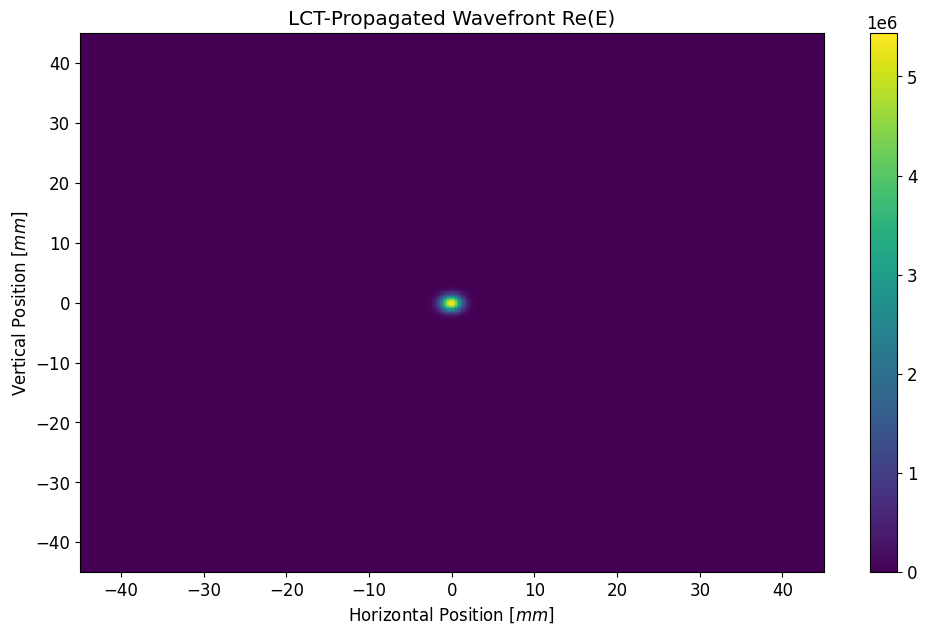

In [30]:
# plot propagated Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_prop_lct,1e3), np.multiply(yvals_prop_lct,1e3), np.real(E_field_prop_lct), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-45, 45)
ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('LCT-Propagated Wavefront Re(E)')

Text(0.5, 1.0, 'LCT-Propagated Wavefront Im(E)')

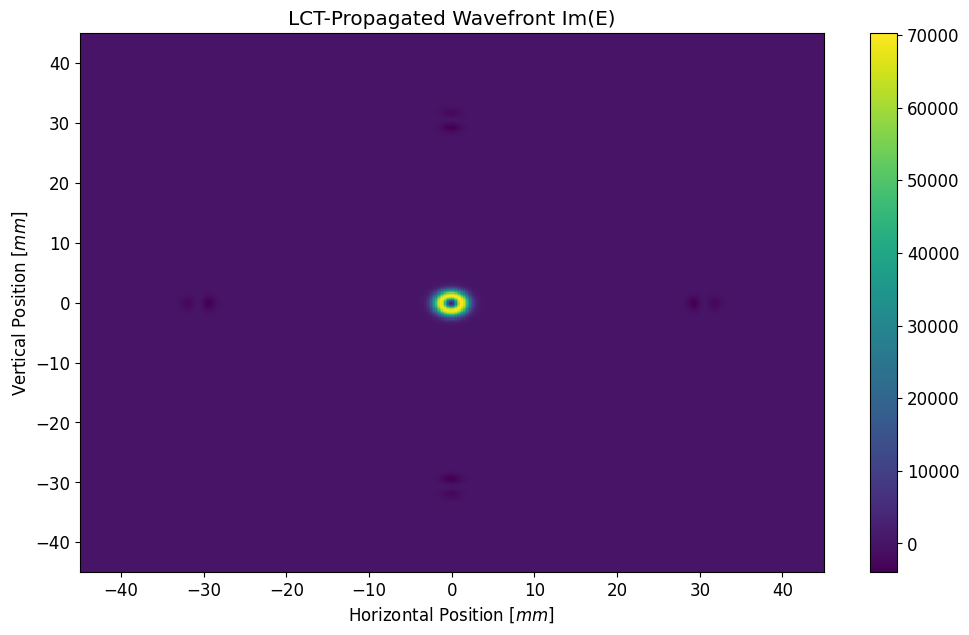

In [31]:
# plot initial Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_prop_lct,1e3), np.multiply(yvals_prop_lct,1e3), np.imag(E_field_prop_lct), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-45, 45)
ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('LCT-Propagated Wavefront Im(E)')

***
##### Propagate via n0n2 SRW

In [32]:
prop_type_n0n2 = 'n0n2_srw'

# create new pulse object
pulse_init_srw = pulse.LaserPulse(params)

pulse_n0n2 = crystal_obj.propagate(pulse_init_srw, prop_type_n0n2)

prop_type = n0n2_srw
Propagated pulse slice  1  of  1
prop_type = n0n2_srw
Propagated pulse slice  1  of  1
prop_type = n0n2_srw
Propagated pulse slice  1  of  1


In [33]:
wfr1 = pulse_n0n2.slice[nslice_cen].wfr

In [34]:
# calculate phase, E field, and intensity from SRW-propagated Gsn wavefront
int1, int1_mesh = srwutil.calc_int_from_wfr(wfr1, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase1, phase1_mesh = srwutil.calc_int_from_wfr(wfr1, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re1, re1_mesh = srwutil.calc_int_from_wfr(wfr1, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im1, im1_mesh = srwutil.calc_int_from_wfr(wfr1, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.17 s)
Extracting intensity and saving it to a file ... completed (lasted 0.1 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)


In [35]:
# reshape into 2D Gsn phase, E field, and intensity arrays
int1_2d = np.array(int1).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
phase1_2d = np.array(phase1).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
re1_2d = np.array(re1).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
im1_2d = np.array(im1).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
print('Size of propagated mesh (coordinate):',np.shape(int1_2d))

Size of propagated mesh (coordinate): (1200, 1200)


In [36]:
# create corresponding x and y arrays for 2D Gsn phase, E field, and intensity arrays
xvals_prop_srw = np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
yvals_prop_srw = np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

In [37]:
# calculate E field total from Re(E) and Im(E)
E_field_prop_srw = re1_2d + np.multiply(im1_2d, 1j)

In [38]:
print(np.size(xvals_prop_srw))
print(wfr1.mesh.nx)

1200
1200


In [39]:
# calculate phase constant and correct propagated E_field

jx_cen_prop_srw = np.floor(wfr1.mesh.nx / 2).astype(int)
jy_cen_prop_srw = np.floor(wfr1.mesh.ny / 2).astype(int)
print(jx_cen_prop_srw, jy_cen_prop_srw)

phase0_srw_prop = E_field_prop_srw[jx_cen_prop_srw, jy_cen_prop_srw] / np.abs(E_field_prop_srw[jx_cen_prop_srw, jy_cen_prop_srw])
print(phase0_srw_prop)

# calculate phase corrected LCT-propagated E field
E_field_prop_srw = E_field_prop_srw / phase0_srw_prop

# calculate phase from corrected LCT-propagated E field
# phase_final_lct = np.angle(E_field_prop_lct)

600 600
(0.99880403-0.04889193j)


Text(0.5, 1.0, 'SRW-Propagated Wavefront Re(E)')

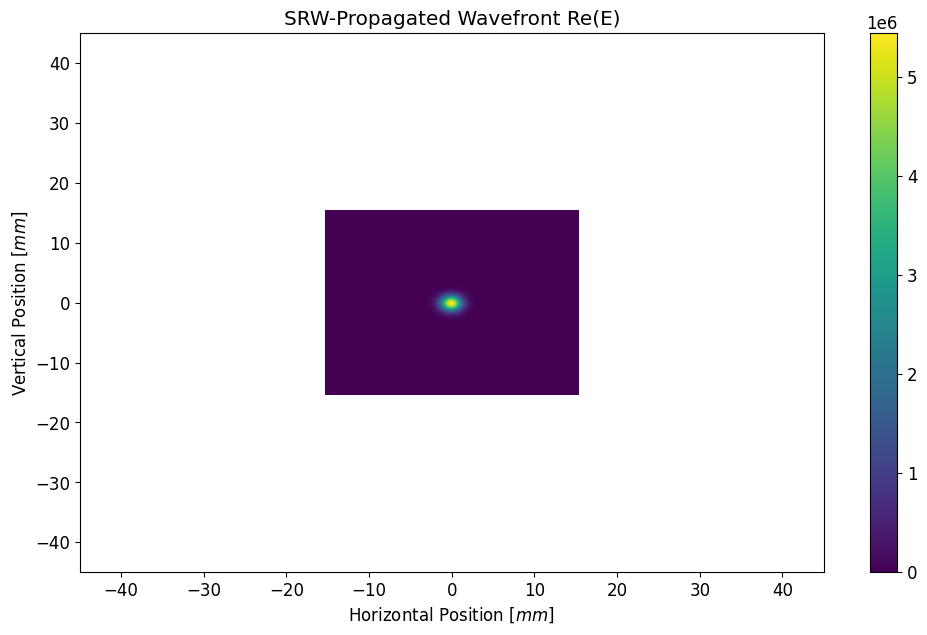

In [40]:
# plot initial Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_prop_srw,1e3), np.multiply(yvals_prop_srw,1e3), np.real(E_field_prop_srw), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-45, 45)
ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('SRW-Propagated Wavefront Re(E)')

Text(0.5, 1.0, 'SRW-Propagated Wavefront Im(E)')

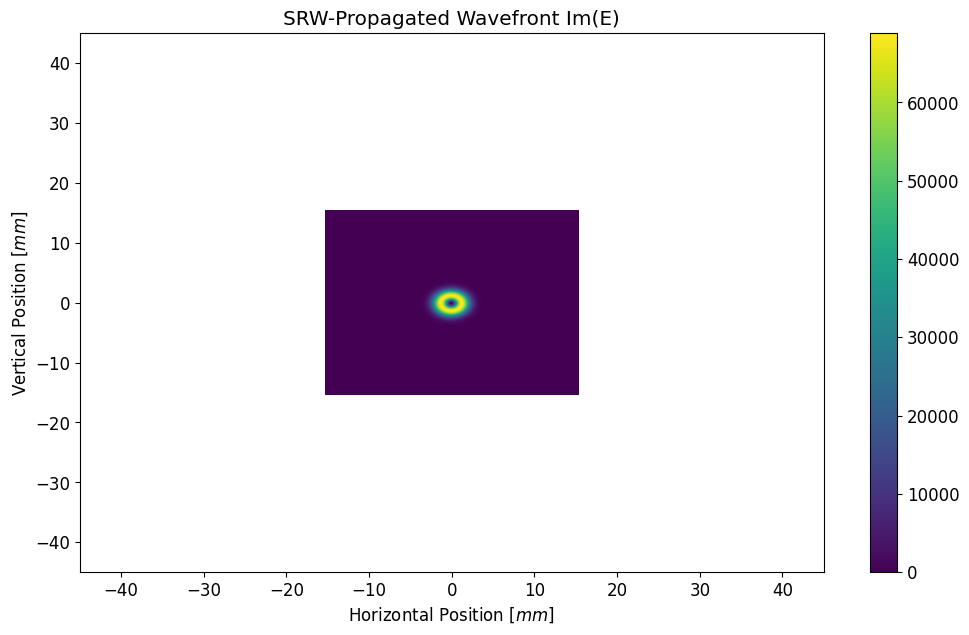

In [41]:
# plot initial Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_prop_srw,1e3), np.multiply(yvals_prop_srw,1e3), np.imag(E_field_prop_srw), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-45, 45)
ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('SRW-Propagated Wavefront Im(E)')

***
##### Propagate via ABCD LCT

In [42]:
# create new pulse object
pulse_init_abcd_lct = pulse.LaserPulse(params)

In [43]:
prop_type_n0n2 = 'abcd_lct'
pulse_prop_abcd_lct = crystal_obj.propagate(pulse_init_abcd_lct, prop_type)
wfr1_abcd_lct = pulse_prop_abcd_lct.slice[nslice_cen].wfr

prop_type = n0n2_lct
Wavelength corresponding to 0.000124 keV: 9.99873 microns
A: 0.999961
B: 0.00333286
C: -0.0236769
D: 0.999961
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
prop_type = n0n2_lct
Wavelength corresponding to 0.000124 keV: 9.99873 microns
A: 0.999961
B: 0.00333286
C: -0.0236769
D: 0.999961
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
Extracting intensity and saving it to a file ... completed (lasted 0.11 s)
prop_type = n0n2_lct
Wavelength corresponding to 0.000124 keV: 9.99873 microns
A: 0.999961
B: 0.00333286
C: -0.0236769
D: 0.999961
Extract

In [44]:
# calculate phase, E field, and intensity from LCT-propagated Gsn wavefront
int1_abcd_lct, int1_mesh_abcd_lct = srwutil.calc_int_from_wfr(wfr1_abcd_lct, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase1_abcd_lct, phase1_mesh_abcd_lct = srwutil.calc_int_from_wfr(wfr1_abcd_lct, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re1_abcd_lct, re1_mesh_abcd_lct = srwutil.calc_int_from_wfr(wfr1_abcd_lct, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im1_abcd_lct, im1_mesh_abcd_lct = srwutil.calc_int_from_wfr(wfr1_abcd_lct, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.13 s)
Extracting intensity and saving it to a file ... completed (lasted 0.19 s)
Extracting intensity and saving it to a file ... completed (lasted 0.13 s)
Extracting intensity and saving it to a file ... completed (lasted 0.12 s)


In [45]:
# reshape into 2D Gsn phase, E field, and intensity arrays
int1_2d_abcd_lct = np.array(int1_abcd_lct).reshape((wfr1_abcd_lct.mesh.nx, wfr1_abcd_lct.mesh.ny), order='C')
phase1_2d_abcd_lct = np.array(phase1_abcd_lct).reshape((wfr1_abcd_lct.mesh.nx, wfr1_abcd_lct.mesh.ny), order='C')
re1_2d_abcd_lct = np.array(re1_abcd_lct).reshape((wfr1_abcd_lct.mesh.nx, wfr1_abcd_lct.mesh.ny), order='C')
im1_2d_abcd_lct = np.array(im1_abcd_lct).reshape((wfr1_abcd_lct.mesh.nx, wfr1_abcd_lct.mesh.ny), order='C')
print('Size of propagated mesh (coordinate):',np.shape(int1_2d_abcd_lct))

Size of propagated mesh (coordinate): (1302, 1302)


In [46]:
# create corresponding x and y arrays for 2D Gsn phase, E field, and intensity arrays
xvals_prop_abcd_lct = np.linspace(wfr1_abcd_lct.mesh.xStart,wfr1_abcd_lct.mesh.xFin,wfr1_abcd_lct.mesh.nx)
yvals_prop_abcd_lct = np.linspace(wfr1_abcd_lct.mesh.yStart,wfr1_abcd_lct.mesh.yFin,wfr1_abcd_lct.mesh.ny)

In [47]:
# calculate E field total from Re(E) and Im(E)
E_field_prop_abcd_lct = re1_2d_abcd_lct + np.multiply(im1_2d_abcd_lct, 1j)

In [48]:
# calculate phase constant and correct propagated E_field

jx_cen_prop_abcd_lct = np.floor(len(xvals_prop_abcd_lct) / 2).astype(int)
jy_cen_prop_abcd_lct = np.floor(len(yvals_prop_abcd_lct) / 2).astype(int)
print(jx_cen_prop_abcd_lct, jy_cen_prop_abcd_lct)

phase0_abcd_lct_prop = E_field_prop_abcd_lct[jx_cen_prop_abcd_lct, jy_cen_prop_abcd_lct] / np.abs(E_field_prop_abcd_lct[jx_cen_prop_abcd_lct, jy_cen_prop_abcd_lct])
print(phase0_abcd_lct_prop)

# calculate phase corrected LCT-propagated E field
E_field_prop_abcd_lct = E_field_prop_abcd_lct / phase0_abcd_lct_prop

# calculate phase from corrected LCT-propagated E field
# phase_final_lct = np.angle(E_field_prop_lct)

651 651
(0.998785-0.049279947j)


Text(0.5, 1.0, 'ABCD LCT-Propagated Wavefront Re(E)')

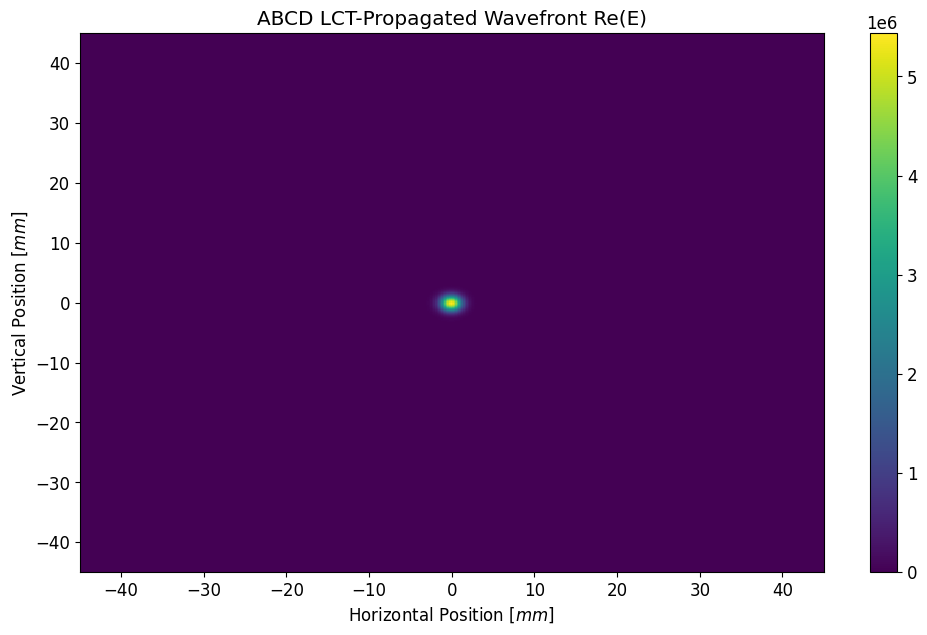

In [49]:
# plot propagated Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_prop_abcd_lct,1e3), np.multiply(yvals_prop_abcd_lct,1e3), np.real(E_field_prop_abcd_lct), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-45, 45)
ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('ABCD LCT-Propagated Wavefront Re(E)')

Text(0.5, 1.0, 'ABCD LCT-Propagated Wavefront Im(E)')

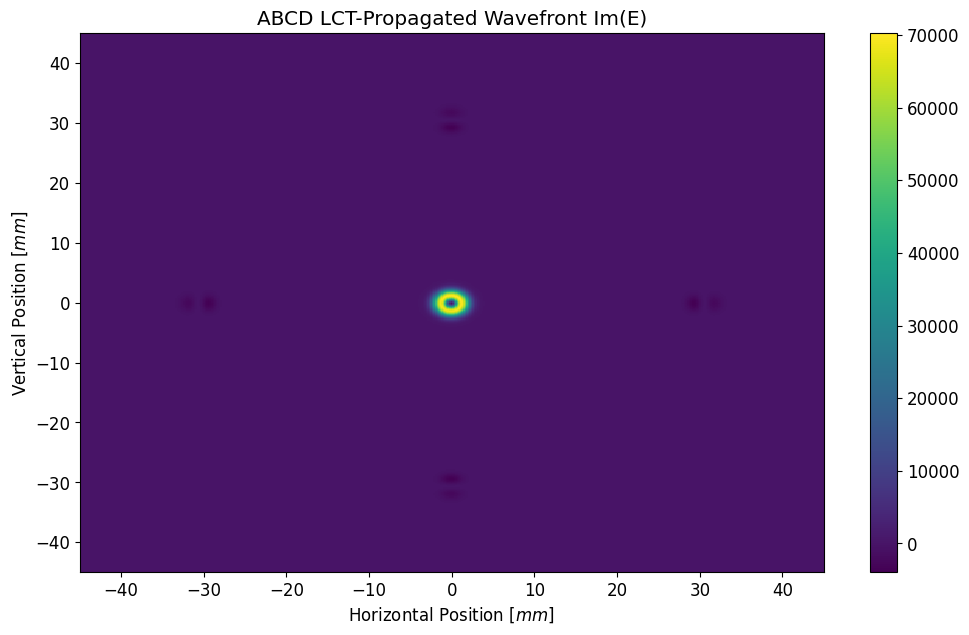

In [50]:
# plot propagated Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_prop_abcd_lct,1e3), np.multiply(yvals_prop_abcd_lct,1e3), np.imag(E_field_prop_abcd_lct), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

ax.set_ylim(-45, 45)
ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('ABCD LCT-Propagated Wavefront Im(E)')

***
##### Compare LCT and SRW

In [51]:
# find center indeces of srw and lct propagated data
# jx_cen_prop_lct = np.floor(len(xvals_prop_lct) / 2).astype(int)
# jy_cen_prop_lct = np.floor(len(yvals_prop_lct) / 2).astype(int)
# print(jx_cen_prop_lct, jy_cen_prop_lct)

# jx_cen_prop_srw = np.floor(wfr1.mesh.nx / 2).astype(int)
# jy_cen_prop_srw = np.floor(wfr1.mesh.ny / 2).astype(int)
# print(jx_cen_prop_srw, jy_cen_prop_srw)

In [52]:
# take horizontal slices of srw and lct propagated data
int_slice_hor_lct = int1_2d_lct[:, jy_cen_prop_lct]
int_slice_hor_abcd_lct = int1_2d_abcd_lct[:, jy_cen_prop_abcd_lct]
int_slice_hor_srw = int1_2d[:, jy_cen_prop_srw]
re_slice_hor_lct = np.real(E_field_prop_lct)[:, jy_cen_prop_lct]
re_slice_hor_abcd_lct = np.real(E_field_prop_abcd_lct)[:, jy_cen_prop_abcd_lct]
re_slice_hor_srw = np.real(E_field_prop_srw)[:, jy_cen_prop_srw]
print(np.shape(re_slice_hor_lct))
im_slice_hor_lct = np.imag(E_field_prop_lct)[:, jy_cen_prop_lct]
im_slice_hor_abcd_lct = np.imag(E_field_prop_abcd_lct)[:, jy_cen_prop_abcd_lct]
im_slice_hor_srw = np.imag(E_field_prop_srw)[:, jy_cen_prop_srw]
# phase1_2d_lct # lct
# phase1_2d # srw
phase_slice_hor_lct = phase1_2d_lct[:, jy_cen_prop_lct]
phase_slice_hor_abcd_lct = phase1_2d_abcd_lct[:, jy_cen_prop_abcd_lct]
phase_slice_hor_srw = phase1_2d[:, jy_cen_prop_srw]

(1302,)


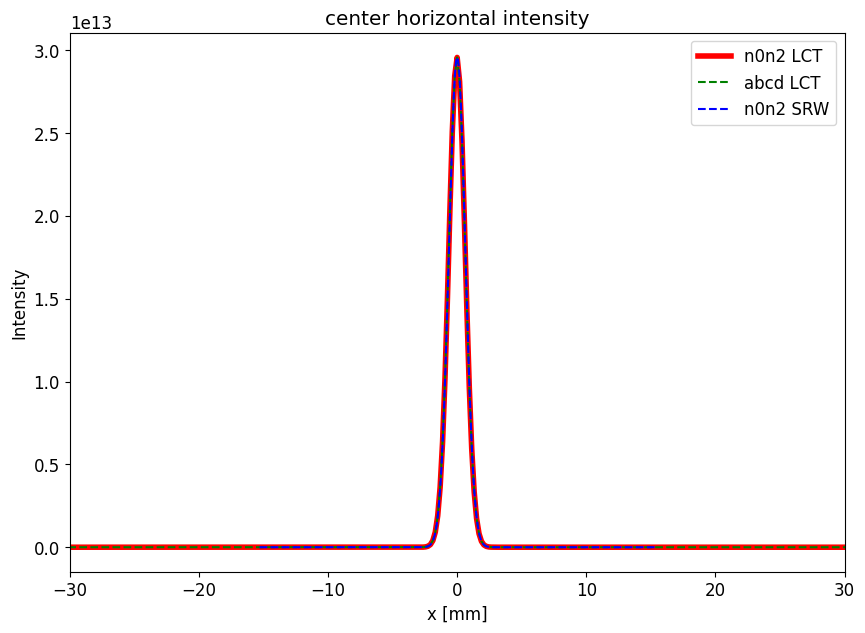

In [58]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(xvals_prop_lct,1e3), int_slice_hor_lct, 'r-', linewidth=4, label = r'n0n2 LCT')
ax.plot(np.multiply(xvals_prop_abcd_lct,1e3), int_slice_hor_abcd_lct, 'g--', label = r'abcd LCT')
ax.plot(np.multiply(xvals_prop_srw,1e3), int_slice_hor_srw, 'b--',  label = r'n0n2 SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-30, 30)
# plt.ylim(0,100)
plt.title('center horizontal intensity')
plt.xlabel('x [mm]')
plt.ylabel(r'Intensity')
plt.legend()

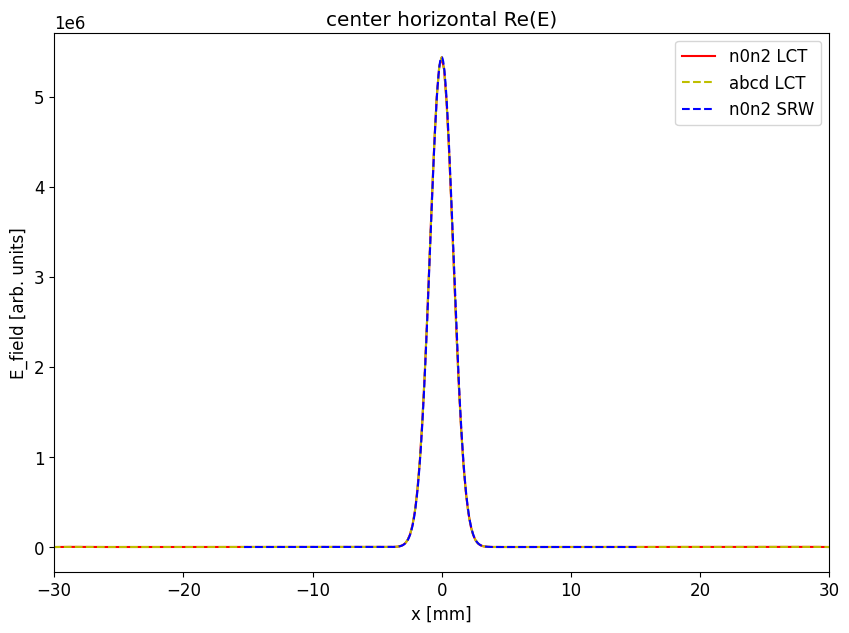

In [59]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(xvals_prop_lct,1e3), re_slice_hor_lct, 'r-', label = r'n0n2 LCT')
ax.plot(np.multiply(xvals_prop_abcd_lct,1e3), re_slice_hor_abcd_lct, 'y--', label = r'abcd LCT')
ax.plot(np.multiply(xvals_prop_srw,1e3), re_slice_hor_srw, 'b--',  label = r'n0n2 SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-30, 30)
# plt.ylim(0,100)
plt.title('center horizontal Re(E)')
plt.xlabel('x [mm]')
plt.ylabel(r'E_field [arb. units]')
plt.legend()

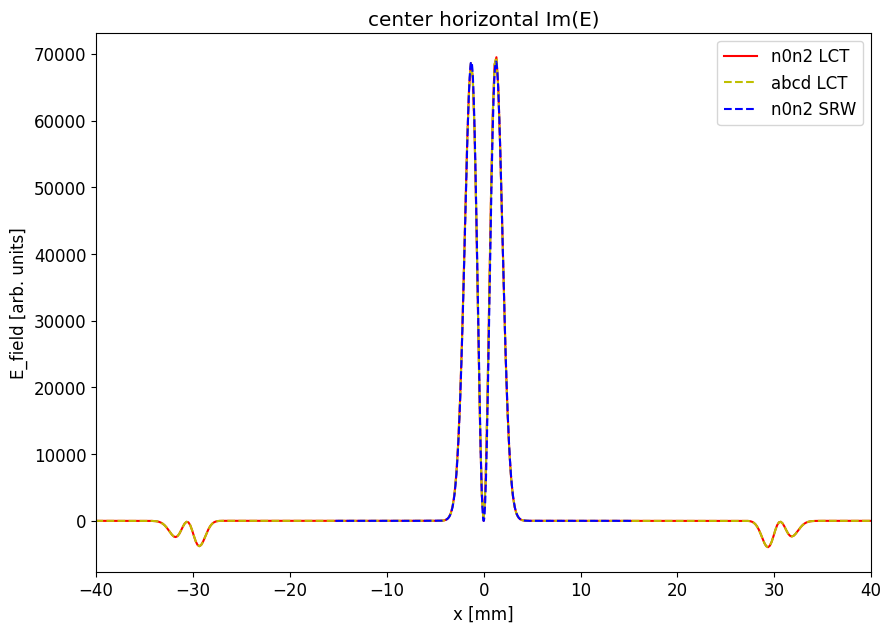

In [60]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(xvals_prop_lct,1e3), im_slice_hor_lct, 'r-', label = r'n0n2 LCT')
ax.plot(np.multiply(xvals_prop_abcd_lct,1e3), im_slice_hor_abcd_lct, 'y--', label = r'abcd LCT')
ax.plot(np.multiply(xvals_prop_srw,1e3), im_slice_hor_srw, 'b--',  label = r'n0n2 SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-40, 40)
# plt.ylim(0,100)
plt.title('center horizontal Im(E)')
plt.xlabel('x [mm]')
plt.ylabel(r'E_field [arb. units]')
plt.legend()

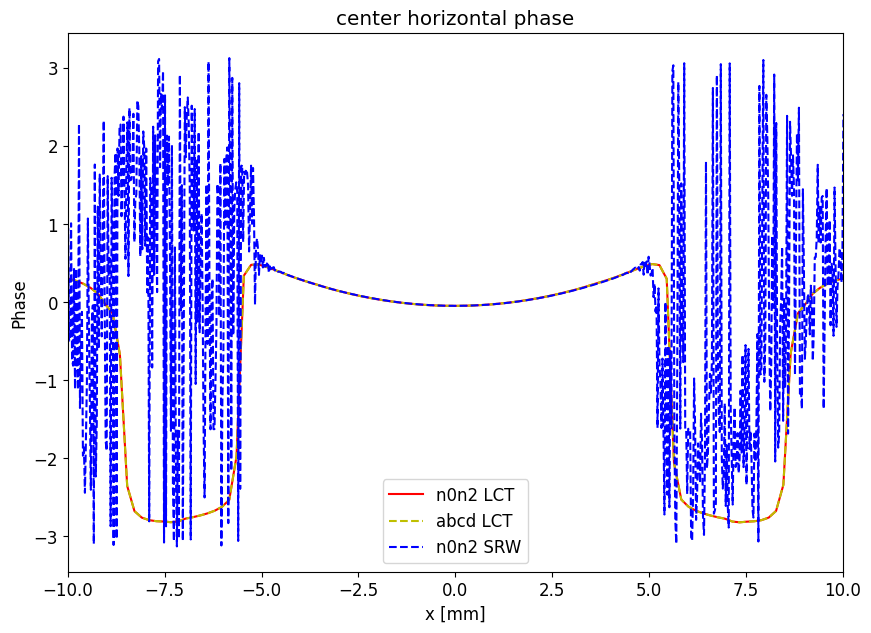

In [56]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(xvals_prop_lct,1e3), phase_slice_hor_lct, 'r-', label = r'n0n2 LCT')
ax.plot(np.multiply(xvals_prop_abcd_lct,1e3), phase_slice_hor_abcd_lct, 'y--', label = r'abcd LCT')
ax.plot(np.multiply(xvals_prop_srw,1e3), phase_slice_hor_srw, 'b--',  label = r'n0n2 SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-10, 10)
# plt.ylim(0,100)
plt.title('center horizontal phase')
plt.xlabel('x [mm]')
plt.ylabel(r'Phase')
plt.legend()

***
##### Compare initial and propagated wavefronts

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(xvals_gsn_init,1e3), phase_slice_hor_init, 'b--',  label = r'initial')
ax.plot(np.multiply(xvals_prop_lct,1e3), phase_slice_hor_lct, 'r-', label = r'propagated')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-10, 10)
# plt.ylim(0,100)
plt.title('center horizontal phase')
plt.xlabel('x [mm]')
plt.ylabel(r'Phase')
plt.legend()

In [ ]:
# n0=1.76
# n2=2
# len_cryst=0.025
# l_scale=1

In [ ]:
# gamma = np.sqrt(n2/n0)

# A = np.cos(gamma*len_cryst)
# B = (1/gamma)*np.sin(gamma*len_cryst)
# C = -gamma*np.sin(gamma*len_cryst)
# D = np.cos(gamma*len_cryst)
# abcd_mat_cryst_crct = np.array([[ A,  B  ],
#                      [ C, D ]])

# print('abcd_mat_cryst (after): %s' %(abcd_mat_cryst_crct))